In [ ]:
# Plot generation for section: Polya distribution (Dirichlet-Multinomial)

In [4]:
# defining and importing stuff
%matplotlib inline 
import numpy as np
import scipy as sc
from matplotlib import pylab as plt
from scipy.special import gamma, digamma, polygamma
from scipy import integrate
from scipy.special import digamma, polygamma

In [5]:
# Approximates KL divergence for 1-D continuous p and q by using numerical integration. 
# Both p and q are continuous probability distributions over RV X. 
# We only know their values at sampled points x.
def kl1_cont_PQ(p,q,x):
    K = len(p)
    theProd = np.zeros(K)
    for k in range(0,K):
        if p[k] > 0.0:
            theProd[k] = p[k]*np.log(p[k]/q[k])
    return integrate.simps(theProd, x, dx=1, axis=-1, even='avg')

def kl1_cont_QP(p,q,x):
    K = len(p)
    theProd = np.zeros(K)
    for k in range(0,K):
        theProd[k] = q[k]*np.log(q[k]/p[k])
    return integrate.simps(theProd, x, dx=1, axis=-1, even='avg')




In [323]:
def get_log_pdash(p_list):
    # returns log average vector of proportions for all observations
    N = len(p_list)
    beforesumming = [(1/N)*np.log(p) for p in p_list]
    summed = []
    for k in range(p_list[0].size):
        ksum = 0
        for p_vec in beforesumming:
            ksum += p_vec[k]
        summed.append(ksum)
    return np.array(summed)

def get_pdash(p_list):
    # returns average vector of proportions for for all observations
    N = len(p_list)
    beforesumming = [(1/N)*(p) for p in p_list]
    summed = []
    for k in range(p_list[0].size):
        ksum = 0
        for p_vec in beforesumming:
            ksum += p_vec[k]
        summed.append(ksum)
    return np.array(summed)

def get_alphas_mle(m_old, s, p_list):
    # get MLE estimate of alphas by Minka's approximation of mean
    log_p_dash = get_log_pdash(p_list)
    K = (m_old[0]).size
    sum_over_j = 0
    for j in range(K):
        sum_over_j += m_old[j]*(log_p_dash[j] - digamma(s*m_old[j]))
    y = np.array(log_p_dash - sum_over_j)
    return inv_digamma(y)
        
def get_m_new(alphas_new):
    # gets the mean vector from the alphas
    return np.array(np.array(alphas_new)/np.sum(alphas_new))

def m_s_to_alphas(m, s):
    # convert mean vector and precision to alphas
    alphas = s*np.array(m)
    return alphas

def alphas_to_m_s(alphas):
    # convert alphas to mean vector and precision
    s= np.sum(alphas)
    m= np.array(alphas)/s
    return m, s

def johnson_kotz(p_list):
    # 2D special case approximation but weird becuse it uses no existing alphas....
    p_dash = get_log_pdash(p_list)
    denom = 1-p_dash[0]-p_dash[1]
    return( np.array([(1-p_dash[1])/denom,(1-p_dash[0])/denom])*0.5)

def johnson(p1,p2):
    print(1-p1-p2)
    print(p1,p2)
    a1 = 1/2*((1-p2)/(1-p1-p2))
    a2 = 1/2*((1-p1)/(1-p1-p2))
    return a1,a2
def approx_digamma(x):
    # approximation to diamma (this is basis for initial approximation for inverse digamma)
    if x >=0.6:
        psi = np.log(x_guess-0.5)
    else:
        psi = 1/x_guess +digamma(1)
    return psi

def inv_digamma(y, tol=1e-10,n_iter=100):
    # approximation for inverse digamma
    if not ((type(y) is list) or (isinstance(y, np.ndarray))):
        y = [y]

    x = []
    for yk in y:
        if yk >= -2.22:
            xk = np.exp(yk) + 0.5
        else:
            xk = -1/(yk-digamma(1))

        for i in range(n_iter):  
            zk = digamma(xk) - yk
            if abs(zk)<tol:
                break
            xk = xk - (zk)/polygamma(1,xk)
        x.append(xk)

    return np.array(x)

def run_comparison_of_approx_methods(pX=np.array([0.2,0.8]),a=np.array([0.5,0.5]),only_message=True):
    da = 0
    # normalisation, don't touch
    ac = gamma(np.sum(a))/np.prod(gamma(a))
    capX = pX.dot(a)/sum(a)

    # sampling of the probs theta0 and theta1
    q1 = np.linspace(5E-5,1.-5E-5,1000)
    q0 = 1. - q1

    # the dirichlet distribution
    f0 = ac*np.power(q0,a[0])*(np.power(q1,a[1]-1.))
    f1 = ac*np.power(q0,a[0]-1.)*(np.power(q1,a[1]))

    # The *** true posterior marginal *** after we summed out X (p)
    fP = (pX[0]*f0+pX[1]*f1)/capX
    f = ac*np.power(q0,a[0]-1.)*(np.power(q1,a[1]-1.))
    area = sc.integrate.simps(fP, q1, dx=1, axis=-1, even='avg')
    fP = fP/area;
    m_pd = fP/f

    # EMDW way
    emdw_a = a*pX;
    emdw_a /= np.sum(emdw_a) 
    print("EMDW's approx before initial alphas added:",emdw_a)
    alphas_em = emdw_a
    print("EMDW's approx:",alphas_em)

    # Johnson's way
    alphas = johnson_kotz([pX])
    alphas /= np.sum(alphas) 
    print("johnson's 2nd order approx before initial alphas added:",alphas)
    alphas_john = alphas
    john_a = alphas
    print("johnson's 2nd order approx:",john_a)
    alphas = a        
    minka_a = aa
    
    # VI way
    new_aa = np.ones(len(aa))
    for i in range(len(aa)):
        new_aa[i] = np.exp(digamma(a[i]) - digamma(np.sum(a)))*pX[i]
        
    print("new aa VI", new_aa)
    new_aa /=np.sum(new_aa)
    print("new aa VI", np.sum(new_aa))
    vb_a = new_aa
    
    if only_message is False:
        minka_a = minka_a + a
        emdw_a = emdw_a+ a
        vb_a = vb_a + a
    print("final MINKA", minka_a)
    print("final EMDW", emdw_a)
    print("final VB", vb_a)

    # diff between minka and emdw
    diff = (minka_a - emdw_a)[0]
    print("Minka - Emdw:", diff)

    aa_emdw = np.array(emdw_a)
    aa_minka = np.array(minka_a)
    aa_john = np.array(john_a)
    aa_vb = np.array(vb_a)

    caa_emdw = gamma(np.sum(aa_emdw))/np.prod(gamma(aa_emdw))
    caa_minka = gamma(np.sum(aa_minka))/np.prod(gamma(aa_minka))
    caa_vb = gamma(np.sum(aa_vb))/np.prod(gamma(aa_vb))
    caa_john = gamma(np.sum(aa_john))/np.prod(gamma(aa_john))

    fQ_emdw = caa_emdw*np.power(q0,aa_emdw[0]+da-1.)*(np.power(q1,aa_emdw[1]-da-1.))
    area = sc.integrate.simps(fQ_emdw, q1, dx=1, axis=-1, even='avg')
    fQ_emdw /= area;
    print((fQ_emdw[0:10]), (m_pd[0:10]))
    fQ_minka = caa_minka*np.power(q0,aa_minka[0]+da-1.)*(np.power(q1,aa_minka[1]-da-1.))
    areab = sc.integrate.simps(fQ_minka, q1, dx=1, axis=-1, even='avg')
    fQ_minka /= areab;
    
    fQ_vb = caa_vb*np.power(q0,aa_vb[0]+da-1.)*(np.power(q1,aa_vb[1]-da-1.))
    areab = sc.integrate.simps(fQ_vb, q1, dx=1, axis=-1, even='avg')
    fQ_vb /= areab;

    fQ_john = caa_john*np.power(q0,aa_john[0]+da-1.)*(np.power(q1,aa_john[1]-da-1.))
    areab = sc.integrate.simps(fQ_john, q1, dx=1, axis=-1, even='avg')
    fQ_john /= areab;
    return q0, q1, fP, fQ_emdw, fQ_minka, fQ_vb, emdw_a, minka_a, vb_a, m_pd

def plot_posterior(q0=None, q1=None, fP=None, fQ_emdw=None, fQ_minka=None,  fQ_vb=None,figstring=""):

#     truePost,= plt.plot(q1,fP,label='True posterior',color='blue')
#     estPost_e,= plt.plot(q1,fQ_emdw,label='Estimated message emdw',color='green')
#     estPost_m,= plt.plot(q1,fQ_minka,label='Estimated message EP',color='orange')
#     estPost_vb,= plt.plot(q1,fQ_vb,label='Estimated message VI',color='brown')
    truePost,= plt.plot(q1,fP,label='True',color='blue')
#     estPost_m,= plt.plot(q1,fQ_minka,label='EP estimate',color='brown')
    estPost_e,= plt.plot(q1,fQ_emdw,label='ALBU/VMP+/Sampling estimate',color='green')

    estPost_vb,= plt.plot(q1,fQ_vb,label='VMP estimate',color='orange')

    plt.rc('text', usetex=True)
    plt.xlabel(r'$\theta_2$ \hspace{5mm} (with $\theta_1 = 1-\theta_2$)',fontsize=16)
    plt.ylabel(r'$p(\theta|\alpha,p_1,p_2)$',
              fontsize=16)
#     plt.title(r'Posterior Dirichlet distribution with $\alpha_0=$%s, $\alpha_1=$%s, $p_0=$%s, $p_1=$%s'%(a[0],a[1],pX[0],pX[1]))
#     plt.legend(handles=[truePost, estPost_e, estPost_m, estPost_vb])
    plt.legend(handles=[truePost,estPost_e, estPost_vb])
    plt.ylim((0,4))
    plt.grid()
    plt.savefig("posterior_"+figstring+".pdf")
    plt.show()

def plot_kl_div(del_a=np.linspace(-0.25,0.25,100), emdw_a=None, minka_a=None, vb_a=None, fP=None,figstring=""):
    da=0
    div_emdw = np.zeros(len(del_a))
    div_act = np.zeros(len(del_a))
    div_minka = np.zeros(len(del_a))
    div_vb = np.zeros(len(del_a))
    div_john = np.zeros(len(del_a))
    div_minka_QP = np.zeros(len(del_a))
    div_emdw_QP = np.zeros(len(del_a))
    div_vb_QP = np.zeros(len(del_a))
    for k in range( len(del_a) ):

        aa_emdw = np.array(emdw_a)
        aa_minka = np.array(minka_a)
        aa_vb = np.array(vb_a)
        
        aa_emdw[0] += del_a[k]
        aa_emdw[1] -= del_a[k]
        aa_minka[0] += del_a[k]
        aa_minka[1] -= del_a[k]
        aa_vb[0] += del_a[k]
        aa_vb[1] -= del_a[k]
            
        caa_emdw = gamma(np.sum(aa_emdw))/np.prod(gamma(aa_emdw))
        caa_minka = gamma(np.sum(aa_minka))/np.prod(gamma(aa_minka))
        caa_vb = gamma(np.sum(aa_vb))/np.prod(gamma(aa_vb))
        
        fQ = caa_emdw*np.power(q0,aa_emdw[0]+da-1.)*(np.power(q1,aa_emdw[1]-da-1.))
        area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
        fQ /= area; #renormalize for the sake of simpson's rule
        div_emdw[k] = kl1_cont_PQ(fQ,fP,q1)
        div_emdw_QP[k] = kl1_cont_QP(fQ,fP,q1)

        fQ = caa_minka*np.power(q0,aa_minka[0]+da-1.)*(np.power(q1,aa_minka[1]-da-1.))
        area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
        fQ /= area; #renormalize for the sake of simpson's rule
        div_minka[k] = kl1_cont_PQ(fQ,fP,q1)
        div_minka_QP[k] = kl1_cont_QP(fQ,fP,q1)
        
        fQ = caa_vb*np.power(q0,aa_vb[0]+da-1.)*(np.power(q1,aa_vb[1]-da-1.))
        area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
        fQ /= area; #renormalize for the sake of simpson's rule
        div_vb[k] = kl1_cont_PQ(fQ,fP,q1)
        div_vb_QP[k] = kl1_cont_QP(fQ,fP,q1)
        

    plt.figure(1)
    plt.plot(del_a,div_minka,color='orange')  
    plt.plot(del_a,div_emdw,color='green') 
    plt.plot(del_a,div_vb,color='brown') 
    plt.plot(del_a,div_minka_QP,color='orange', linestyle='dashed')  
    plt.plot(del_a,div_emdw_QP,color='green', linestyle='dashed') 
    plt.plot(del_a,div_vb_QP,color='brown', linestyle='dashed') 
    plt.xlabel(r'Delta $\alpha$',fontsize=16)
    plt.ylabel('KL(Q,P)',fontsize=16)
#     plt.title(r'KL divergences vs delta alpha with $\alpha_1=$%s, $\alpha_2=$%s, $p_1=$%s, $p_2=$%s'%(a[0],a[1],pX[0],pX[1]))
    plt.savefig("KL_" + figstring +".pdf")
    plt.xlim(-0.25, 0.25)
    plt.grid(True)
    plt.show()
    




#### Set stuff up
You can play around with these. The last one is the x axis for the plots.

alpha_0=0.6 ,alpha_1=0.4 ,p_0=0.1 ,p_=0.9
EMDW's approx before initial alphas added: [0.14285714 0.85714286]
EMDW's approx: [0.14285714 0.85714286]
johnson's 2nd order approx before initial alphas added: [0.25076546 0.74923454]
johnson's 2nd order approx: [0.25076546 0.74923454]
Minka's approx before initial alphas added: [0.21704389 0.78295611]
new aa VI [0.03815919 0.12374536]
new aa VI 1.0
final MINKA [0.21704389 0.78295611]
final EMDW [0.14285714 0.85714286]
final VB [0.23568943 0.76431057]
Minka - Emdw: 0.07418674720880858
[0.59902157 0.38803739 0.35296872 0.33377967 0.32080415 0.31111663
 0.30345106 0.2971482  0.29182262 0.28723016] [0.23691783 0.23881412 0.24071042 0.24260671 0.244503   0.24639929
 0.24829558 0.25019187 0.25208817 0.25398446]
EMDW's approx before initial alphas added: [0.14285714 0.85714286]
EMDW's approx: [0.14285714 0.85714286]
johnson's 2nd order approx before initial alphas added: [0.25076546 0.74923454]
johnson's 2nd order approx: [0.25076546 0.74923454]
Mi

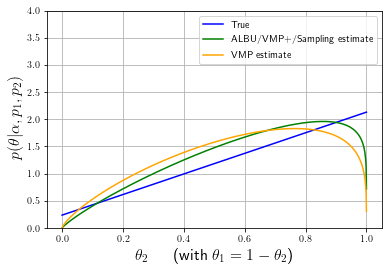

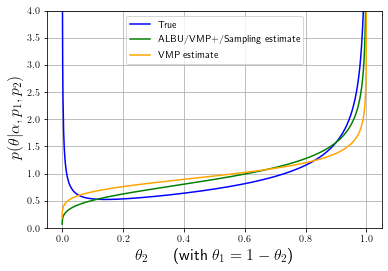

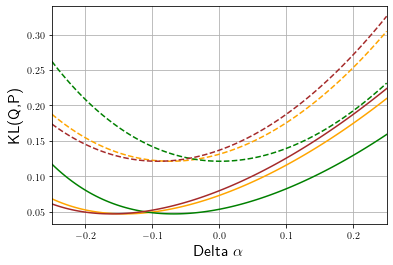

In [326]:
alphas_const = 1


pX = np.array([0.1,0.9])# distribution (incoming from right) p(X|Y=y)
a1 = 0.6
a2 = 1-a1
a = np.array([a1,a2])*alphas_const  # distribution (incoming from left) p(theta;alpha)
del_a = np.linspace(-0.25,0.25,100)
figstring = "alpha_0="+str(a[0])+" ,alpha_1="+str(a[1])+" ,p_0="+str(pX[0])+" ,p_="+str(pX[1])
print(figstring)
q0, q1, fP, fQ_emdw, fQ_minka, fQ_vb, emdw_a, minka_a, vb_a, m_pd =run_comparison_of_approx_methods(pX=pX,a=a)
# plot_posterior(q0=q0, q1=q1, fP=m_pd, fQ_emdw=fQ_emdw, fQ_minka=fQ_minka, fQ_vb=fQ_vb,figstring=figstring)
# plot_kl_div(del_a=del_a, emdw_a=emdw_a, minka_a=minka_a,vb_a=vb_a,fP=m_pd,figstring=figstring)
q0, q1, fP, fQ_emdw, fQ_minka, fQ_vb, emdw_a, minka_a, vb_a, m_pd =run_comparison_of_approx_methods(pX=pX,a=a, only_message=False)
f = fP/m_pd
plot_posterior(q0=q0, q1=q1, fP=fP/f, fQ_emdw=fQ_emdw/f, fQ_minka=fQ_minka/f,fQ_vb=fQ_vb/f, figstring=figstring+"nm_msg")
plot_posterior(q0=q0, q1=q1, fP=fP, fQ_emdw=fQ_emdw, fQ_minka=fQ_minka,fQ_vb=fQ_vb, figstring=figstring)
plot_kl_div(del_a=del_a, emdw_a=emdw_a, minka_a=minka_a, vb_a=vb_a, fP=fP,figstring=figstring)


In [298]:
ak = 1

obs = [0.5, 0.9, 0.99, 0.78]
obother = np.ones(len(obs))-obs
a = [100,1000]


In [299]:
anewemdw = 0
for i,ob in enumerate(obs):
    anewemdw = ak*ob/(ob*a[0] + (1-ob)*a[1])  + ak
    print(anewemdw)


1.000909090909091
1.0047368421052632
1.0090825688073395
1.0026174496644296


In [300]:
aknew = 0
for i,ob in enumerate(obs):
    aknew = ak*(digamma(ak+ob)-digamma(ak))  + ak
    print(aknew)


1.6137056388801094
1.9333998260655925
1.9935303709469476
1.8473618692164164
